# 1.importing libraries and loading the data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('demand_inventory.csv')
data

,Unnamed: 0,Date,Product_ID,Demand,Inventory
0,0,2023-06-01,P1,51,5500
1,1,2023-06-02,P1,141,5449
2,2,2023-06-03,P1,172,5308
3,3,2023-06-04,P1,91,5136
4,4,2023-06-05,P1,198,5045
...,...,...,...,...,...
57,57,2023-07-28,P1,174,0
58,58,2023-07-29,P1,72,0
59,59,2023-07-30,P1,52,0
60,60,2023-07-31,P1,188,0



There’s an unnamed column in the dataset.It should be dropped.

In [3]:
data = data.drop(columns=['Unnamed: 0'])

# 2.Data preparation

In [4]:
data.shape

(62, 4)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        62 non-null     object
 1   Product_ID  62 non-null     object
 2   Demand      62 non-null     int64 
 3   Inventory   62 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.1+ KB


The data contains 2 object columns and 3 numerical columns.Notice the date column is listed as object we will change it later.

In [6]:
data.isnull().sum()

Date          0
Product_ID    0
Demand        0
Inventory     0
dtype: int64

Wow no missing values

In [7]:
#dropping duplicates
data = data.drop_duplicates()

In [8]:
data.describe()

,Demand,Inventory
count,62.000000,62.000000
mean,120.709677,2073.822581
std,44.852906,1840.782144
min,51.000000,0.000000
25%,85.000000,25.500000
50%,124.000000,1908.000000
75%,152.750000,3594.250000
max,199.000000,5500.000000


In [9]:
data.describe(include='object')

,Date,Product_ID
count,62,62
unique,62,1
top,2023-06-01,P1
freq,1,62


This is definitely a time series problem,lets dive into the trends of the data 

In [10]:
data['Date'] = pd.to_datetime(data['Date'],
                                        format='%Y/%m/%d')


#### Demand over time

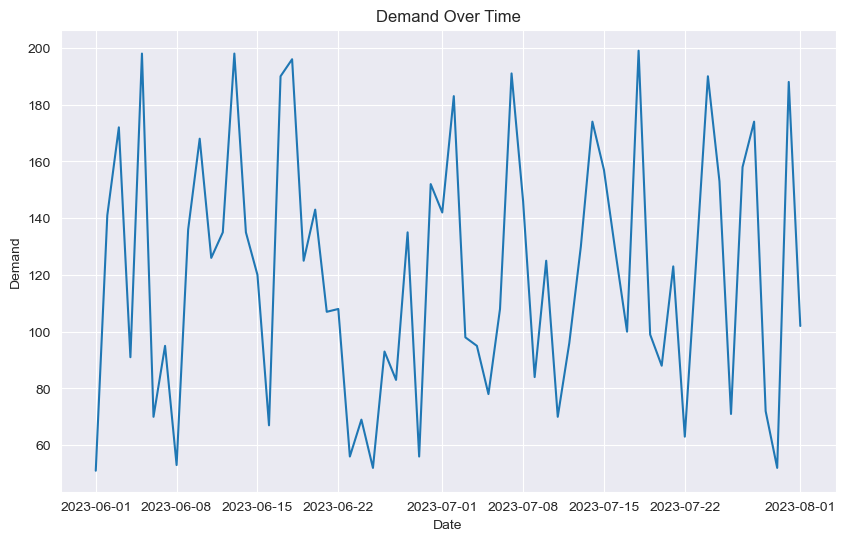

In [11]:
plt.figure(figsize=(10, 6))
fig = sns.lineplot(data=data, x='Date', y='Demand')
plt.title('Demand Over Time')
plt.show()


I can see seasonal patterns in the demand.

#### Inventory over time

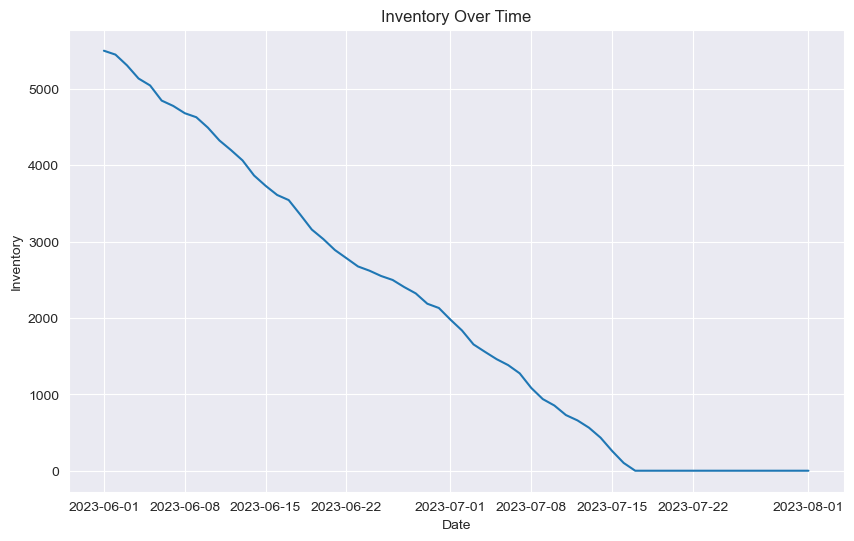

In [12]:
plt.figure(figsize=(10, 6))
fig = sns.lineplot(data=data, x='Date', y='Inventory')
plt.title('Inventory Over Time')
plt.show()

### Demand Forecasting

We will forecast the demand using SARIMA.Let’s first calculate the value of p and q using ACF and PACF plots.

In [13]:
time_series = data.set_index('Date')['Demand']
differenced_series = time_series.diff().dropna()

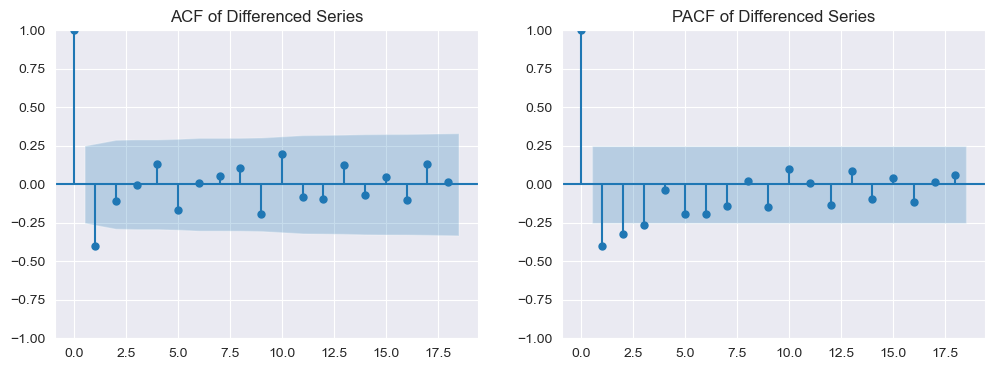

In [14]:
# Plot ACF and PACF of differenced time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1], method='ywm')
axes[0].set_title('ACF of Differenced Series')
axes[1].set_title('PACF of Differenced Series')
plt.show()

The value of p, d, and q will be 1, 1, 1.
p=1 from the PACF,d=1 because it is non-stationary,q=1 from ACF

#### forecasting demand for the next ten days



In [15]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 2) #2 because the data contains a time period of 2 months only
model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

future_steps = 10
predictions = model_fit.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
print(predictions)

2023-08-02    117
2023-08-03    116
2023-08-04    130
2023-08-05    114
2023-08-06    128
2023-08-07    115
2023-08-08    129
2023-08-09    115
2023-08-10    129
2023-08-11    115
Freq: D, Name: predicted_mean, dtype: int64


In [16]:
# Create date indices for the future predictions
future_dates = pd.date_range(start=time_series.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')

# Create a pandas Series with the predicted values and date indices
forecasted_demand = pd.Series(predictions, index=future_dates)

# Initial inventory level
initial_inventory = 5500

# Lead time (number of days it takes to replenish inventory) 
lead_time = 1 # it's different for every business, 1 is an example

# Service level (probability of not stocking out)
service_level = 0.95 # it's different for every business, 0.95 is an example

# Calculate the optimal order quantity using the Newsvendor formula
z = np.abs(np.percentile(forecasted_demand, 100 * (1 - service_level)))
order_quantity = np.ceil(forecasted_demand.mean() + z).astype(int)

# Calculate the reorder point
reorder_point = forecasted_demand.mean() * lead_time + z

# Calculate the optimal safety stock
safety_stock = reorder_point - forecasted_demand.mean() * lead_time

# Calculate the total cost (holding cost + stockout cost)
holding_cost = 0.1  # it's different for every business, 0.1 is an example
stockout_cost = 10  # # it's different for every business, 10 is an example
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * np.maximum(0, forecasted_demand.mean() * lead_time - initial_inventory)

# Calculate the total cost
total_cost = total_holding_cost + total_stockout_cost

print("Optimal Order Quantity:", order_quantity)
print("Reorder Point:", reorder_point)
print("Safety Stock:", safety_stock)
print("Total Cost:", total_cost)

Optimal Order Quantity: 236
Reorder Point: 235.25
Safety Stock: 114.45
Total Cost: 561.8000000000001


1.Optimal Order Quantity: 236 – The optimal order quantity refers to the quantity of a product that should be ordered from suppliers when the inventory level reaches a certain point. In this case, an optimal order quantity of 236 units has been calculated.                                                                     
2.Reorder Point: 235.25 – The reorder point is the inventory level at which a new order should be placed to replenish stock before it runs out. In this case, a reorder point of 235.25 units has been calculated, which means that when the inventory reaches or falls below this level, an order should be placed to replenish stock.           
3.Safety Stock: 114.45 – Safety stock is the additional inventory kept on hand to account for uncertainties in demand and supply. It acts as a buffer against unexpected variations in demand or lead time. In this case, a safety stock of 114.45 units has been calculated, which helps ensure that there’s enough inventory to cover potential fluctuations in demand or lead time.                   
4.Total Cost: 561.80 – The total cost represents the combined costs associated with inventory management. In this case, the total cost has been calculated as approximately 561.80 units based on the order quantity, reorder point, safety stock, and associated costs.